In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
import glob
from tensorflow import keras
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

drive.mount('/content/drive/')
data_pathrsn = 'drive/MyDrive/archive/Data/images_original/'
# data_path = "GTZAN/features_30_sec.csv"
# data_path3 = "GTZAN/features_3_sec.csv"
# data = pd.read_csv(data_path)
# data3 = pd.read_csv(data_path3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Mounted at /content/drive/
cuda


In [ ]:
images = []
cate_name = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
labels = []
for i in range(len(cate_name)):
  folder_path = data_pathrsn + cate_name[i]
  file_pattern = folder_path + '/*.png'

  for file_path in glob.glob(file_pattern):
    labels.append(cate_name[i])
    image = tf.keras.preprocessing.image.load_img(file_path)
    # image = tf.keras.preprocessing.image.load_img('drive/MyDrive/archive/Data/images_original/blues/blues00000.png')
    # image = tf.image.decode_png(image, channels=4)
    # image = image.convert('RGB')
    # Convert the image to a Pillow Image object
    image = tf.keras.preprocessing.image.img_to_array(image)
    # image = image.astype('uint8')
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    # print(np.array(np.shape(image)))
    image = image.resize((288, 288))
    # print(np.array(np.shape(image)))
    image = tf.keras.preprocessing.image.img_to_array(image)
    images.append(image)

encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 新段落

In [ ]:

# Preprocess the data
x_train = np.array(x_train).astype("float32") / 255.0
x_test = np.array(x_test).astype("float32") / 255.0

earlystop_callback = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# Define the ResNet model
def resnet_block(inputs, num_filters=16, kernel_size=3, strides=1, activation="relu"):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def resnet18(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = resnet_block(inputs)

    # First conv block
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = resnet_block(x, num_filters=64)
    for _ in range(2):
        y = resnet_block(x, num_filters=64)
        y = resnet_block(y, num_filters=64, activation=None)
        x = layers.Add()([x, y])
        x = layers.Activation('relu')(x)
        
    x = resnet_block(x, num_filters=128, strides=2)
    for _ in range(2):
        y = resnet_block(x, num_filters=128)
        y = resnet_block(y, num_filters=128, activation=None)
        x = layers.Add()([x, y])
        x = layers.Activation('relu')(x)
        
    x = resnet_block(x, num_filters=256, strides=2)
    for _ in range(2):
        y = resnet_block(x, num_filters=256)
        y = resnet_block(y, num_filters=256, activation=None)
        x = layers.Add()([x, y])
        x = layers.Activation('relu')(x)
        
    x = resnet_block(x, num_filters=512, strides=2)
    for _ in range(2):
        y = resnet_block(x, num_filters=512)
        y = resnet_block(y, num_filters=512, activation=None)
        x = layers.Add()([x, y])
        x = layers.Activation('relu')(x)
    
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

# Create the ResNet-18 model
model = resnet18((288, 288, 3), 10)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# model = model.fit(device)

# Train the model
with tf.device('/GPU:0'):
  history = model.fit(x_train, y_train, batch_size=64, epochs=180, validation_split=0.2)

# Evaluate the model
test_scores = model.evaluate(x_test, y_test, verbose=2)  
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/110
10/10 [==============================] - 47s 2s/step - loss: 2.2300 - accuracy: 0.1894 - val_loss: 3.4823 - val_accuracy: 0.0750
Epoch 2/110
10/10 [==============================] - 11s 1s/step - loss: 1.8225 - accuracy: 0.3427 - val_loss: 18.3459 - val_accuracy: 0.0625
Epoch 3/110
10/10 [==============================] - 11s 1s/step - loss: 1.6665 - accuracy: 0.3897 - val_loss: 12.2823 - val_accuracy: 0.0625
Epoch 4/110
10/10 [==============================] - 11s 1s/step - loss: 1.5203 - accuracy: 0.4664 - val_loss: 11.3820 - val_accuracy: 0.0625
Epoch 5/110
10/10 [==============================] - 11s 1s/step - loss: 1.4528 - accuracy: 0.4914 - val_loss: 9.7642 - val_accuracy: 0.1688
Epoch 6/110
10/10 [==============================] - 11s 1s/step - loss: 1.4131 - accuracy: 0.4836 - val_loss: 10.0819 - val_accuracy: 0.1375
Epoch 7/110
10/10 [==============================] - 11s 1s/step - loss: 1.3420 - accuracy: 0.5258 - val_loss: 8.1238 - val_accuracy: 0.1312
Epoch 8/1

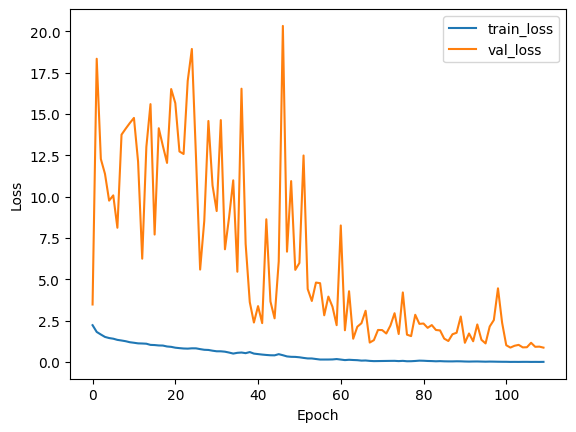

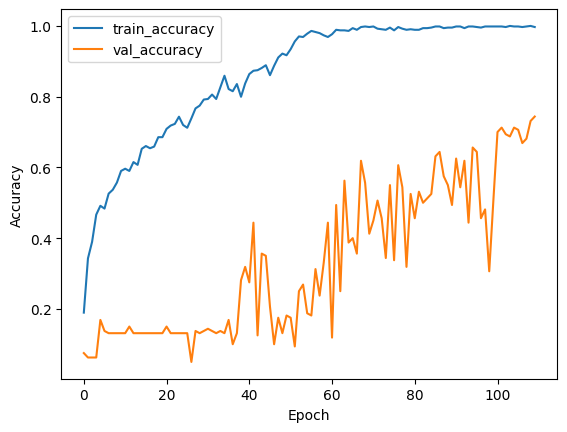

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()